In [79]:
from sklearn import model_selection
import pandas as pd
import numpy as np

In [108]:
# load data into a table by extracting user and item numbers
ratings = pd.read_csv('data/data_train.csv', dtype={'Prediction': np.int})
pos = ratings.Id.str.extract('r([0-9]+)_c([0-9]+)', expand=True)
ratings['User'] = pos[0].astype(np.int)
ratings['Item'] = pos[1].astype(np.int)
ratings.head()

,Id,Prediction,User,Item
0,r44_c1,4,44,1
1,r61_c1,3,61,1
2,r67_c1,4,67,1
3,r72_c1,3,72,1
4,r86_c1,5,86,1


In [109]:
train_x, test_x = model_selection.train_test_split(ratings, test_size=0.05, train_size=0.1)

In [110]:
train_x.head()

,Id,Prediction,User,Item
688570,r2091_c591,5,2091,591
903427,r170_c706,3,170,706
232375,r4011_c192,2,4011,192
463957,r8842_c398,4,8842,398
139491,r8233_c119,3,8233,119


In [84]:
#train_x.to_csv('train_x.csv', index=False)

In [85]:
#test_x.to_csv('test_x.csv', index=False)

In [111]:
categorical_train_y = np.zeros([train_x.shape[0], 5])
categorical_train_y[np.arange(train_x.shape[0]), train_x.Prediction - 1] = 1
categorical_train_y.shape

(117695, 5)

In [112]:
categorical_test_y = np.zeros([test_x.shape[0], 5])
categorical_test_y[np.arange(test_x.shape[0]), test_x.Prediction - 1] = 1
categorical_test_y.shape

(58848, 5)

In [113]:
n_users = train_x['User'].max()
n_items = train_x['Item'].max()

In [89]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [90]:
import keras
from keras import layers
from keras import models
from keras import optimizers

In [91]:
def shallow_net():
    features = 48
    
    input_i = layers.Input(shape=[1])
    i = layers.Embedding(n_items + 1, features)(input_i)
    i = layers.Flatten()(i)
    i = layers.normalization.BatchNormalization()(i)

    input_u = layers.Input(shape=[1])
    u = layers.Embedding(n_users + 1, features)(input_u)
    u = layers.Flatten()(u)
    u = layers.normalization.BatchNormalization()(u)
    
    nn = layers.concatenate([i, u])
    
    nn = layers.Dense(512, activation='relu')(nn)
    nn = layers.Dropout(0.5)(nn)
    nn = layers.normalization.BatchNormalization()(nn)
    
    nn = layers.Dense(128, activation='relu')(nn)
    
    output = layers.Dense(5, activation='softmax')(nn)
    
    model = models.Model([input_i, input_u], output)
    model.compile(optimizer='adamax', loss='categorical_crossentropy')
    return model
model = shallow_net()

In [92]:
def simple_deep_net():
    features = 48
    
    input_i = layers.Input(shape=[1])
    i = layers.Embedding(n_items + 1, features)(input_i)
    i = layers.Flatten()(i)
    i = layers.normalization.BatchNormalization()(i)

    input_u = layers.Input(shape=[1])
    u = layers.Embedding(n_users + 1, features)(input_u)
    u = layers.Flatten()(u)
    u = layers.normalization.BatchNormalization()(u)
    
    nn = layers.concatenate([i, u])
    
    nn = layers.Dense(1024, activation='relu')(nn)
    nn = layers.Dropout(0.5)(nn)
    nn = layers.normalization.BatchNormalization()(nn)
    nn = layers.Dense(512, activation='relu')(nn)
    nn = layers.Dropout(0.5)(nn)
    nn = layers.normalization.BatchNormalization()(nn)
    nn = layers.Dense(256, activation='relu')(nn)
    nn = layers.Dropout(0.5)(nn)
    nn = layers.normalization.BatchNormalization()(nn)
    nn = layers.Dense(128, activation='relu')(nn)
    
    output = layers.Dense(5, activation='softmax')(nn)
    
    model = models.Model([input_i, input_u], output)
    model.compile(optimizer='sgd', loss='categorical_crossentropy')
    return model
model = simple_deep_net()

In [93]:
epochs = model.fit(
    [train_x.Item, train_x.User], train_y,
    validation_data=([test_x.Item, test_x.User], test_y),
    batch_size=2048,
    epochs=20
)

Train on 117695 samples, validate on 58848 samples
Epoch 1/20
117695/117695 [==============================] - 37s 312us/step - loss: 1.7759 - val_loss: 1.5331

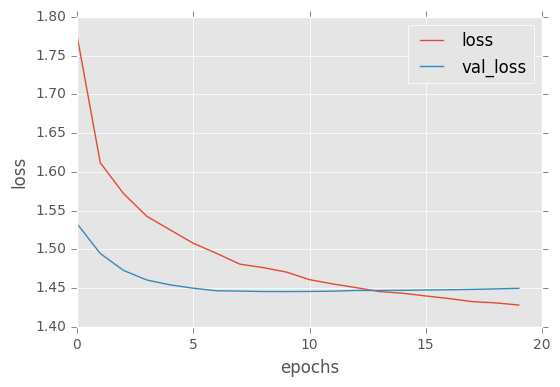

In [94]:
plt.plot(epochs.history['loss'], label='loss')
plt.plot(epochs.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
model.save('model1.h5')

In [ ]:
def simple_dense_net():
    features = 256
    
    input_i = layers.Input(shape=[1])    
    i = layers.Embedding(n_items + 1, features)(input_i)
    i = layers.Reshape((features,))(i)
    i = layers.normalization.BatchNormalization()(i)

    input_u = layers.Input(shape=[1])
    u = layers.Embedding(n_users + 1, features)(input_u)
    u = layers.Flatten()(u)
    u = layers.Reshape((features,))(u)
    u = layers.normalization.BatchNormalization()(u)
    
    nn = layers.concatenate([i, u])    
    nn = layers.Dropout(0.5)(nn)
    nn = layers.Dense(features, activation='relu')(nn)
    nn = layers.Dropout(0.5)(nn)
    
    output =  layers.Dense(1, activation='linear')(nn)
    
    model = models.Model([input_i, input_u], output)
    model.compile(optimizer='sgd', loss='mean_squared_error')
    return model

model = simple_dense_net()

In [ ]:
history = model.fit(
    [train_x.Item, train_x.User], train_x.Prediction,
    validation_data=([test_x.Item, test_x.User], test_x.Prediction),
    #batch_size=2048,
    epochs=20
)

Train on 117695 samples, validate on 58848 samples
Epoch 1/20
117695/117695 [==============================] - 35s 294us/step - loss: 1.3847 - val_loss: 1.5151

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [131]:
model

In [133]:
model.get_config()

{'input_layers': [['input_48', 0, 0], ['input_49', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 1),
    'dtype': 'float32',
    'name': 'input_49',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_49'},
  {'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 1),
    'dtype': 'float32',
    'name': 'input_48',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_48'},
  {'class_name': 'Embedding',
   'config': {'activity_regularizer': None,
    'batch_input_shape': (None, None),
    'dtype': 'float32',
    'embeddings_constraint': None,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'maxval': 0.05, 'minval': -0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'input_dim': 10001,
    'input_length': None,
    'mask_zero': False,
    'name': 'embedding_50',
    'output_dim': 256,
    'trainable': True},
   'inbound_nodes': [[['input_49', 0, 0, {}]]],
   'name'